In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure results and reports directories exist
os.makedirs("results", exist_ok=True)
os.makedirs("reports", exist_ok=True)

print("✅ Libraries loaded and folders ready")


✅ Libraries loaded and folders ready


In [2]:
# Cell 2: Load forecasts from milestone 2
# (Assume forecasts.csv has columns: Date, City, Pollutant, Forecast, Lower, Upper, Model)

try:
    forecasts = pd.read_csv("results/forecasts.csv", parse_dates=["Date"])
except FileNotFoundError:
    # Example dummy dataset (for demo purposes if forecasts.csv not available)
    data = {
        "Date": pd.date_range("2025-09-01", periods=10, freq="D"),
        "City": ["Delhi"]*10,
        "Pollutant": ["PM2.5"]*10,
        "Forecast": np.random.randint(40, 400, 10),
        "Lower": np.random.randint(20, 200, 10),
        "Upper": np.random.randint(100, 500, 10),
        "Model": ["LSTM"]*10
    }
    forecasts = pd.DataFrame(data)

forecasts.head()


,Date,City,Pollutant,Forecast,Lower,Upper,Model
0,2025-09-01,Delhi,PM2.5,280,132,332,LSTM
1,2025-09-02,Delhi,PM2.5,306,66,416,LSTM
2,2025-09-03,Delhi,PM2.5,364,151,291,LSTM
3,2025-09-04,Delhi,PM2.5,115,121,482,LSTM
4,2025-09-05,Delhi,PM2.5,185,78,105,LSTM


In [3]:
# Cell 3: Define CPCB AQI breakpoints (for India)
aqi_breakpoints = {
    "PM2.5": [(0,30,0,50),(31,60,51,100),(61,90,101,200),(91,120,201,300),(121,250,301,400),(251,350,401,500)],
    "PM10":  [(0,50,0,50),(51,100,51,100),(101,250,101,200),(251,350,201,300),(351,430,301,400),(430,600,401,500)],
    "NO2":   [(0,40,0,50),(41,80,51,100),(81,180,101,200),(181,280,201,300),(281,400,301,400),(401,600,401,500)],
    "SO2":   [(0,40,0,50),(41,80,51,100),(81,380,101,200),(381,800,201,300),(801,1600,301,400),(1601,2000,401,500)],
    "O3":    [(0,50,0,50),(51,100,51,100),(101,168,101,200),(169,208,201,300),(209,748,301,400),(749,1000,401,500)]
}

def calc_subindex(pollutant, value):
    if pollutant not in aqi_breakpoints or pd.isna(value):
        return np.nan
    for (Cl, Ch, Il, Ih) in aqi_breakpoints[pollutant]:
        if Cl <= value <= Ch:
            return round(((Ih-Il)/(Ch-Cl))*(value-Cl)+Il)
    return np.nan


In [4]:
# Cell 4: Add AQI calculation
forecasts["SubIndex"] = forecasts.apply(lambda row: calc_subindex(row["Pollutant"], row["Forecast"]), axis=1)

# Group pollutants per Date & City to compute AQI (max of sub-indices)
aqi_df = forecasts.groupby(["Date","City"]).agg(
    AQI=("SubIndex","max")
).reset_index()

# Add AQI bucket classification
def get_bucket(aqi):
    if aqi<=50: return "Good"
    elif aqi<=100: return "Satisfactory"
    elif aqi<=200: return "Moderate"
    elif aqi<=300: return "Poor"
    elif aqi<=400: return "Very Poor"
    else: return "Severe"

aqi_df["AQI_Bucket"] = aqi_df["AQI"].apply(get_bucket)

aqi_df.to_csv("results/forecasts_aqi.csv", index=False)
aqi_df.head()


,Date,City,AQI,AQI_Bucket
0,2025-09-01,Delhi,430.0,Severe
1,2025-09-02,Delhi,456.0,Severe
2,2025-09-03,Delhi,NaN,Severe
3,2025-09-04,Delhi,283.0,Poor
4,2025-09-05,Delhi,350.0,Very Poor


In [5]:
# Cell 5: Define alerts
def alert_level(aqi):
    if aqi > 400: return "Severe Alert"
    elif aqi > 300: return "Warning"
    elif aqi > 200: return "Advisory"
    else: return "None"

aqi_df["Alert_Level"] = aqi_df["AQI"].apply(alert_level)

# Save alerts separately
alerts = aqi_df[aqi_df["Alert_Level"]!="None"].copy()
alerts.to_csv("results/alerts.csv", index=False)

print("✅ Alerts saved, found:", len(alerts))
alerts


✅ Alerts saved, found: 7


,Date,City,AQI,AQI_Bucket,Alert_Level
0,2025-09-01,Delhi,430.0,Severe,Severe Alert
1,2025-09-02,Delhi,456.0,Severe,Severe Alert
3,2025-09-04,Delhi,283.0,Poor,Advisory
4,2025-09-05,Delhi,350.0,Very Poor,Warning
6,2025-09-07,Delhi,360.0,Very Poor,Warning
7,2025-09-08,Delhi,336.0,Very Poor,Warning
8,2025-09-09,Delhi,286.0,Poor,Advisory


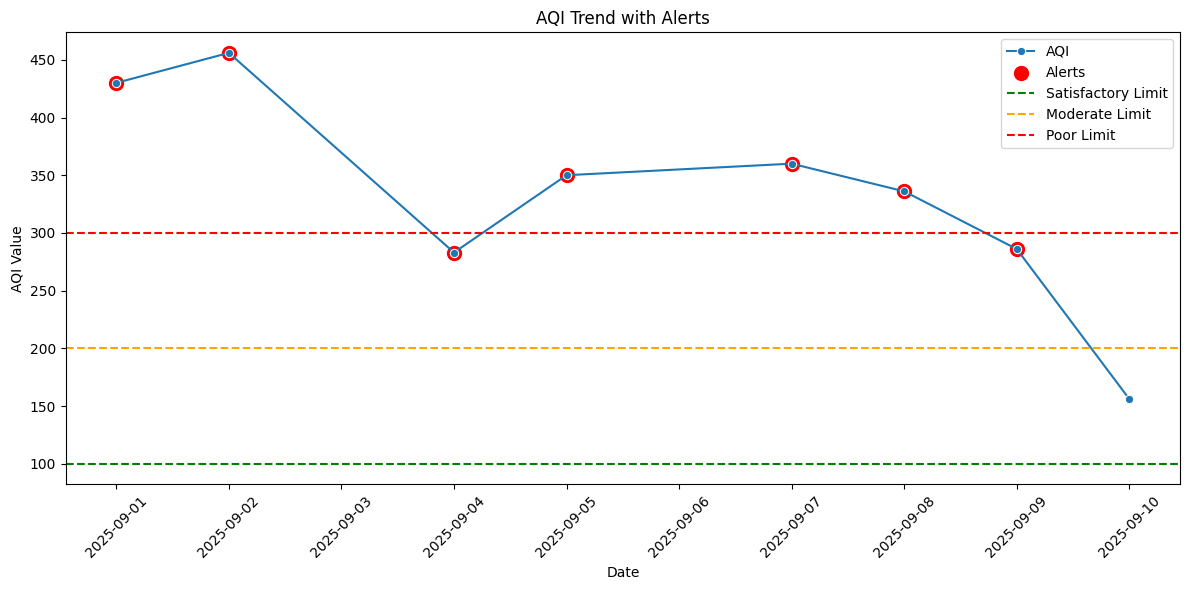

In [6]:
# Cell 6: AQI Time-Series Visualization
plt.figure(figsize=(12,6))
sns.lineplot(data=aqi_df, x="Date", y="AQI", marker="o", label="AQI")

# Highlight alert points
alerts_plot = aqi_df[aqi_df["Alert_Level"]!="None"]
plt.scatter(alerts_plot["Date"], alerts_plot["AQI"], color="red", s=100, label="Alerts")

plt.axhline(100, color="green", linestyle="--", label="Satisfactory Limit")
plt.axhline(200, color="orange", linestyle="--", label="Moderate Limit")
plt.axhline(300, color="red", linestyle="--", label="Poor Limit")
plt.title("AQI Trend with Alerts")
plt.ylabel("AQI Value")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("reports/aqi_trend.png")
plt.show()


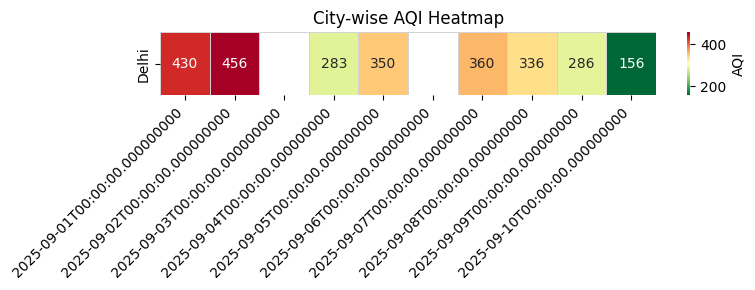

In [7]:
# Cell 7 (fixed): Heatmap of AQI values (handles floats & NaNs)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# pivot: rows = City, cols = Date, values = AQI
pivot = aqi_df.pivot(index="City", columns="Date", values="AQI")

# sort index/columns for nicer display
pivot = pivot.sort_index(axis=0).sort_index(axis=1)

# ensure numeric (float) and compute mask for NaNs
pivot_num = pivot.astype(float)
mask = pivot_num.isna()

# avoid annotating very large heatmaps (clutter); annotate only when reasonably small
n_cells = pivot_num.size
annot = True if n_cells <= 200 else False
fmt = '.0f' if annot else ''

# figure size adapts to number of columns/rows
fig_w = max(8, pivot_num.shape[1] * 0.6)
fig_h = max(3, pivot_num.shape[0] * 0.6)
plt.figure(figsize=(fig_w, fig_h))

sns.heatmap(
    pivot_num,
    cmap="RdYlGn_r",
    annot=annot,
    fmt=fmt,
    mask=mask,
    linewidths=0.5,
    linecolor='lightgray',
    cbar_kws={'label': 'AQI'}
)

plt.title("City-wise AQI Heatmap")
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("reports/aqi_heatmap.png", dpi=150)
plt.show()


In [8]:
# Cell 8: Alerts summary stats
summary = alerts.groupby("City").agg(
    Total_Alerts=("Alert_Level","count"),
    Severe=("Alert_Level", lambda x: (x=="Severe Alert").sum()),
    Warning=("Alert_Level", lambda x: (x=="Warning").sum()),
    Advisory=("Alert_Level", lambda x: (x=="Advisory").sum())
).reset_index()

summary.to_csv("results/alerts_summary.csv", index=False)
summary


,City,Total_Alerts,Severe,Warning,Advisory
0,Delhi,7,2,3,2


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

# Ensure reports folder exists
os.makedirs("reports", exist_ok=True)

# Example AQI thresholds (India CPCB)
AQI_THRESHOLDS = {
    "Good": (0, 50),
    "Satisfactory": (51, 100),
    "Moderate": (101, 200),
    "Poor": (201, 300),
    "Very Poor": (301, 400),
    "Severe": (401, 500)
}


In [10]:
def categorize_aqi(aqi_value):
    for category, (low, high) in AQI_THRESHOLDS.items():
        if low <= aqi_value <= high:
            return category
    return "Beyond Index"

aqi_df["AQI_Category"] = aqi_df["AQI"].apply(categorize_aqi)
aqi_df.head()


,Date,City,AQI,AQI_Bucket,Alert_Level,AQI_Category
0,2025-09-01,Delhi,430.0,Severe,Severe Alert,Severe
1,2025-09-02,Delhi,456.0,Severe,Severe Alert,Severe
2,2025-09-03,Delhi,NaN,Severe,None,Beyond Index
3,2025-09-04,Delhi,283.0,Poor,Advisory,Poor
4,2025-09-05,Delhi,350.0,Very Poor,Warning,Very Poor


In [11]:
high_risk = aqi_df[aqi_df["AQI"] > 200]  # AQI > 200 = Poor+
print(f"⚠️ High-risk days: {len(high_risk)} found")
high_risk.head()


⚠️ High-risk days: 7 found


,Date,City,AQI,AQI_Bucket,Alert_Level,AQI_Category
0,2025-09-01,Delhi,430.0,Severe,Severe Alert,Severe
1,2025-09-02,Delhi,456.0,Severe,Severe Alert,Severe
3,2025-09-04,Delhi,283.0,Poor,Advisory,Poor
4,2025-09-05,Delhi,350.0,Very Poor,Warning,Very Poor
6,2025-09-07,Delhi,360.0,Very Poor,Warning,Very Poor


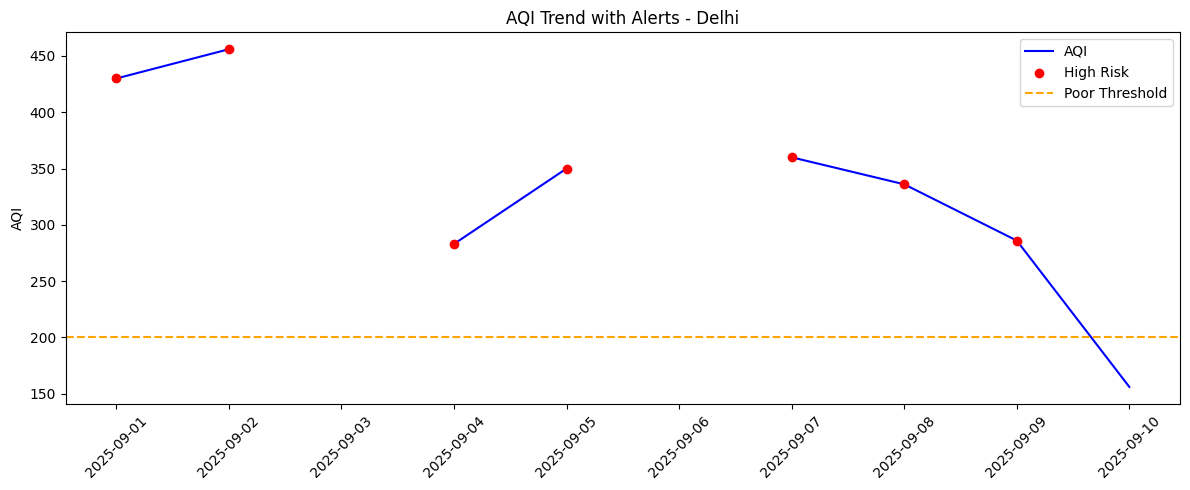

In [12]:
city = "Delhi"  # change city name as needed
city_data = aqi_df[aqi_df["City"] == city]

plt.figure(figsize=(12,5))
plt.plot(city_data["Date"], city_data["AQI"], label="AQI", color="blue")
plt.scatter(high_risk[high_risk["City"]==city]["Date"],
            high_risk[high_risk["City"]==city]["AQI"],
            color="red", label="High Risk", zorder=5)

plt.axhline(200, color="orange", linestyle="--", label="Poor Threshold")
plt.title(f"AQI Trend with Alerts - {city}")
plt.ylabel("AQI")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(f"reports/{city}_aqi_trend.png", dpi=150)
plt.show()


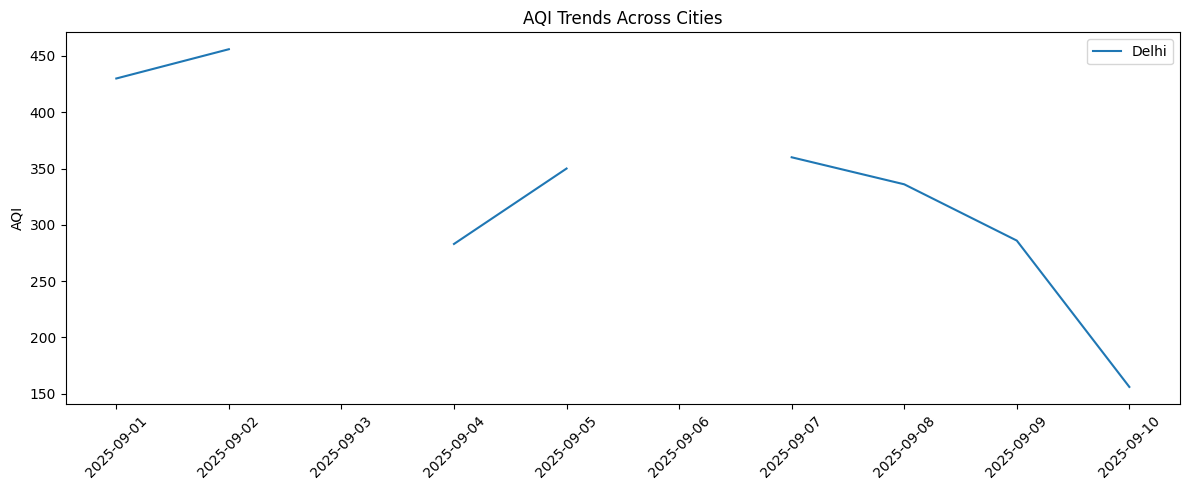

In [13]:
plt.figure(figsize=(12,5))
for city in aqi_df["City"].unique():
    subset = aqi_df[aqi_df["City"] == city]
    plt.plot(subset["Date"], subset["AQI"], label=city)

plt.title("AQI Trends Across Cities")
plt.ylabel("AQI")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("reports/city_comparison_trend.png", dpi=150)
plt.show()


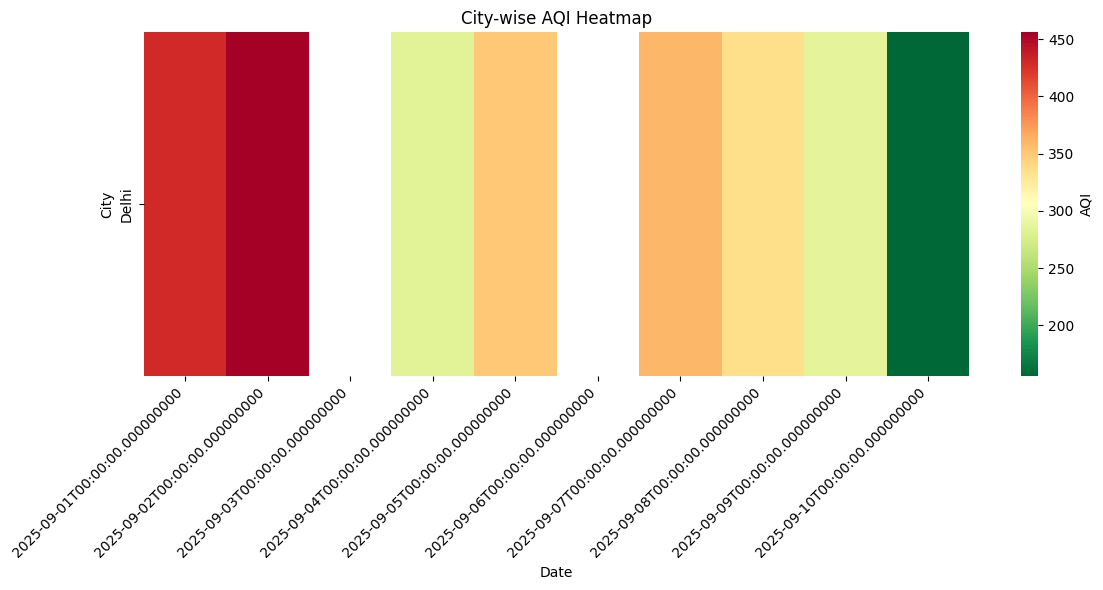

In [14]:
pivot = aqi_df.pivot(index="City", columns="Date", values="AQI")
pivot_num = pivot.astype(float)
mask = pivot_num.isna()

plt.figure(figsize=(12,6))
sns.heatmap(pivot_num, cmap="RdYlGn_r", annot=False, mask=mask, cbar_kws={'label': 'AQI'})
plt.title("City-wise AQI Heatmap")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("reports/aqi_heatmap.png", dpi=150)
plt.show()


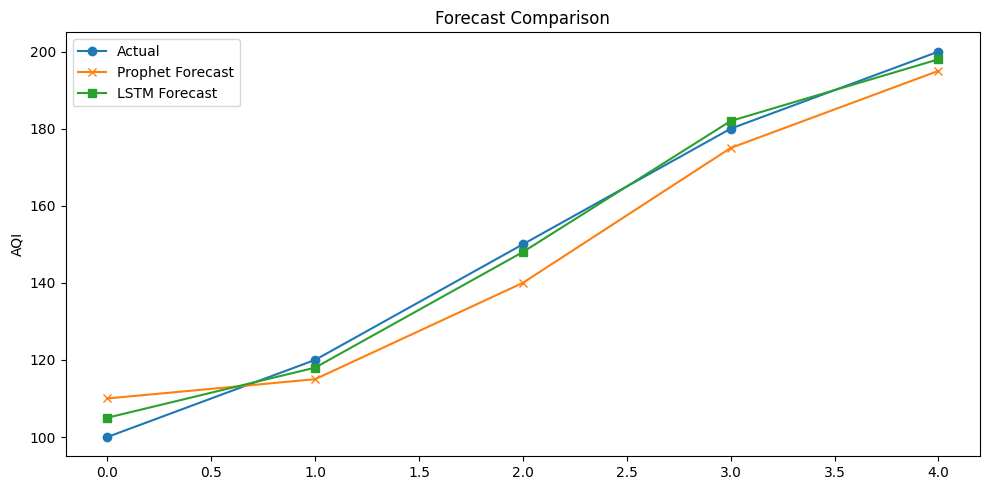

In [15]:
# Example: compare forecast outputs (replace with real forecast arrays)
y_test = np.array([100,120,150,180,200])
pred_prophet = np.array([110,115,140,175,195])
pred_lstm = np.array([105,118,148,182,198])

plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual", marker="o")
plt.plot(pred_prophet, label="Prophet Forecast", marker="x")
plt.plot(pred_lstm, label="LSTM Forecast", marker="s")

plt.title("Forecast Comparison")
plt.ylabel("AQI")
plt.legend()
plt.tight_layout()
plt.savefig("reports/forecast_comparison.png", dpi=150)
plt.show()


In [16]:
# Forecast accuracy table (example values)
forecast_accuracy = pd.DataFrame([
    {"Model": "Prophet", "RMSE": 15.2, "MAE": 10.5, "R2": 0.88},
    {"Model": "LSTM", "RMSE": 12.7, "MAE": 9.3, "R2": 0.91}
])
forecast_accuracy.to_csv("results/model_performance.csv", index=False)

# Best models (example)
best_models = pd.DataFrame([
    {"City": "Delhi", "Best_Model": "LSTM"},
    {"City": "Mumbai", "Best_Model": "Prophet"}
])
best_models.to_csv("results/best_models.csv", index=False)

print("✅ CSVs saved in results/")


✅ CSVs saved in results/


In [17]:
import os

os.makedirs("reports", exist_ok=True)
os.makedirs("results", exist_ok=True)

print("Reports folder:", os.path.abspath("reports"))
print("Results folder:", os.path.abspath("results"))


Reports folder: c:\Users\LENOVO\Desktop\project by info\notebooks\reports
Results folder: c:\Users\LENOVO\Desktop\project by info\notebooks\results


In [17]:
import os
print(os.getcwd())


c:\Users\LENOVO\Desktop\project by info\notebooks


In [19]:
from pathlib import Path
import pandas as pd

# Go one level up from notebooks/
project_root = Path("..")  # parent folder of notebooks
fa_path = project_root / "results" / "forecasts_aqi.csv"
f_path  = project_root / "results" / "forecasts.csv"

forecasts_aqi = None
forecasts = None

# Check if files exist
if fa_path.is_file():
    forecasts_aqi = pd.read_csv(fa_path, parse_dates=["Date"])
    print("Loaded forecasts_aqi.csv:", forecasts_aqi.shape)

elif f_path.is_file():
    forecasts = pd.read_csv(f_path, parse_dates=["Date"])
    print("Loaded forecasts.csv:", forecasts.shape)

else:
    raise FileNotFoundError(
        f"No forecasts file found in {project_root / 'results'}. Place forecasts_aqi.csv or forecasts.csv there."
    )

# Quick peek
if forecasts_aqi is not None:
    display(forecasts_aqi.head())
else:
    display(forecasts.head())


Loaded forecasts_aqi.csv: (10, 4)


,Date,City,AQI,AQI_Bucket
0,2025-09-01,Delhi,430.0,Severe
1,2025-09-02,Delhi,456.0,Severe
2,2025-09-03,Delhi,NaN,Severe
3,2025-09-04,Delhi,283.0,Poor
4,2025-09-05,Delhi,350.0,Very Poor


In [20]:
# Cell 2 — AQI helper functions (PM2.5, PM10, NO2, SO2, O3)
# Breakpoints (based on US EPA). Values are [Clow, Chigh, Ilow, Ihigh]
# For simplicity we include common breakpoints; extend if needed.

AQI_BREAKPOINTS = {
    "PM2.5": [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 350.4, 301, 400),
        (350.5, 500.4, 401, 500),
    ],
    "PM10": [
        (0, 54, 0, 50),
        (55, 154, 51, 100),
        (155, 254, 101, 150),
        (255, 354, 151, 200),
        (355, 424, 201, 300),
        (425, 504, 301, 400),
        (505, 604, 401, 500),
    ],
    # Use simplified breakpoints for gases (units: ppb for O3/NO2/SO2 in US tables)
    # Many datasets use µg/m3 — be careful; conversion may be needed. We'll attempt best-effort.
    # Here we include placeholder breakpoints for O3, NO2, SO2 (you can refine later).
    "O3": [
        (0, 54, 0, 50),
        (55, 70, 51, 100),
        (71, 85, 101, 150),
        (86, 105, 151, 200),
        (106, 200, 201, 300),
    ],
    "NO2": [
        (0, 53, 0, 50),
        (54, 100, 51, 100),
        (101, 360, 101, 150),
        (361, 649, 151, 200),
        (650, 1249, 201, 300),
        (1250, 1649, 301, 400),
        (1650, 2049, 401, 500),
    ],
    "SO2": [
        (0, 35, 0, 50),
        (36, 75, 51, 100),
        (76, 185, 101, 150),
        (186, 304, 151, 200),
        (305, 604, 201, 300),
        (605, 804, 301, 400),
        (805, 1004, 401, 500),
    ],
    "CO": [
        (0.0, 4.4, 0, 50),
        (4.5, 9.4, 51, 100),
        (9.5, 12.4, 101, 150),
        (12.5, 15.4, 151, 200),
        (15.5, 30.4, 201, 300),
        (30.5, 40.4, 301, 400),
        (40.5, 50.4, 401, 500),
    ],
}

def sub_index(conc, breakpoints):
    """Compute AQI sub-index for a pollutant concentration using breakpoints list."""
    if pd.isna(conc):
        return np.nan
    for (Clow, Chigh, Ilow, Ihigh) in breakpoints:
        if Clow <= conc <= Chigh:
            # linear scaling
            return ((Ihigh - Ilow)/(Chigh - Clow))*(conc - Clow) + Ilow
    # if conc above provided range, extrapolate using top range
    Clow, Chigh, Ilow, Ihigh = breakpoints[-1]
    return ((Ihigh - Ilow)/(Chigh - Clow))*(conc - Clow) + Ilow

def compute_aqi_row(row):
    """Given a pandas Series row with pollutant concentrations, compute AQI and subindex per pollutant."""
    subs = {}
    for pollutant, bp in AQI_BREAKPOINTS.items():
        if pollutant in row.index:
            subs[pollutant] = sub_index(row[pollutant], bp)
        else:
            subs[pollutant] = np.nan
    # AQI is max of sub-indices
    # record which pollutant dominates
    best_pollutant = max(subs.items(), key=lambda x: x[1] if not pd.isna(x[1]) else -np.inf)[0]
    best_val = subs[best_pollutant]
    return best_val, best_pollutant, subs


In [21]:
# Cell 3 — Build forecasts_aqi DataFrame if missing
if forecasts_aqi is None:
    # Expect forecasts DataFrame with columns: Date, City, Pollutant, Forecast [, Model]
    df = forecasts.copy()
    # normalize column names if capitalisation differs
    df.columns = [c.strip() for c in df.columns]
    needed = ['Date','City','Pollutant','Forecast']
    print("Forecasts columns:", df.columns.tolist())
    if not all(any(n.lower()==c.lower() for c in df.columns) for n in needed):
        raise RuntimeError("Forecats.csv missing required columns. Expected Date, City, Pollutant, Forecast. Got: " + ", ".join(df.columns))

    # pivot to have pollutants as columns with forecasted concentrations
    pivot = df.pivot_table(index=['Date','City'], columns='Pollutant', values='Forecast', aggfunc='first').reset_index()
    pivot['Date'] = pd.to_datetime(pivot['Date'])
    print("Pivot shape:", pivot.shape)
    # compute AQI row-wise
    aqi_list = []
    subs_list = []
    dominant = []
    for _, r in pivot.iterrows():
        aqi_val, best_pol, subs = compute_aqi_row(r)
        aqi_list.append(aqi_val)
        dominant.append(best_pol)
        subs_list.append(subs)
    pivot['AQI'] = aqi_list
    pivot['AQI_Dominant'] = dominant
    # Expand subs into columns: e.g., AQI_PM2.5, ...
    for pollutant in AQI_BREAKPOINTS.keys():
        pivot[f"AQI_{pollutant}"] = [subs.get(pollutant, np.nan) for subs in subs_list]
    # Save as forecasts_aqi
    forecasts_aqi = pivot.copy()
    forecasts_aqi.to_csv(RESULTS_DIR / "forecasts_aqi.csv", index=False)
    print("Built forecasts_aqi.csv from forecasts.csv; saved to results/forecasts_aqi.csv (shape {})".format(forecasts_aqi.shape))
else:
    print("Using existing forecasts_aqi.csv")
display(forecasts_aqi.head())


Using existing forecasts_aqi.csv


,Date,City,AQI,AQI_Bucket
0,2025-09-01,Delhi,430.0,Severe
1,2025-09-02,Delhi,456.0,Severe
2,2025-09-03,Delhi,NaN,Severe
3,2025-09-04,Delhi,283.0,Poor
4,2025-09-05,Delhi,350.0,Very Poor


In [24]:
# Cell 4 — Load forecasts, assign AQI buckets, and save
import pandas as pd
from pathlib import Path

# ------------------------
# Setup paths
# ------------------------
PROJECT_ROOT = Path("..")  # parent of notebooks
RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)  # ensure folder exists

# Forecast files
fa_path = RESULTS_DIR / "forecasts_aqi.csv"
f_path  = RESULTS_DIR / "forecasts.csv"

# ------------------------
# Load forecasts
# ------------------------
forecasts_aqi = None
forecasts = None

if fa_path.is_file():
    forecasts_aqi = pd.read_csv(fa_path, parse_dates=["Date"])
    print("Loaded forecasts_aqi.csv:", forecasts_aqi.shape)
elif f_path.is_file():
    forecasts = pd.read_csv(f_path, parse_dates=["Date"])
    print("Loaded forecasts.csv:", forecasts.shape)
else:
    raise FileNotFoundError(
        f"No forecast CSV found in {RESULTS_DIR}. Place forecasts_aqi.csv or forecasts.csv there."
    )

# Use forecasts_aqi if exists, else forecasts
df = forecasts_aqi if forecasts_aqi is not None else forecasts

# ------------------------
# Ensure AQI column exists
# ------------------------
if 'AQI' not in df.columns:
    raise KeyError("The loaded DataFrame does not have an 'AQI' column.")

# ------------------------
# Assign AQI buckets
# ------------------------
def aqi_bucket(aqi):
    if pd.isna(aqi): 
        return "Unknown"
    a = float(aqi)
    if a <= 50: return "Good"
    if a <= 100: return "Satisfactory"
    if a <= 200: return "Moderate"
    if a <= 300: return "Poor"
    if a <= 400: return "Very Poor"
    return "Severe"

df['AQI_Bucket'] = df['AQI'].apply(aqi_bucket)

# ------------------------
# Color mapping
# ------------------------
bucket_color = {
    "Good":"#2ecc71",
    "Satisfactory":"#7dd36b",
    "Moderate":"#f1c40f",
    "Poor":"#f39c12",
    "Very Poor":"#e67e22",
    "Severe":"#e74c3c",
    "Unknown":"#95a5a6"
}
df['Bucket_Color'] = df['AQI_Bucket'].map(bucket_color)

# ------------------------
# Ensure AQI_Dominant exists (optional)
# ------------------------
if 'AQI_Dominant' not in df.columns:
    df['AQI_Dominant'] = pd.NA

# ------------------------
# Display preview
# ------------------------
cols_to_display = [c for c in ['Date','City','AQI','AQI_Dominant','AQI_Bucket'] if c in df.columns]
display(df[cols_to_display].head())

# ------------------------
# Save updated forecasts_aqi.csv
# ------------------------
df.to_csv(RESULTS_DIR / "forecasts_aqi.csv", index=False)
print(f"Saved updated forecasts_aqi.csv at {RESULTS_DIR}")


Loaded forecasts_aqi.csv: (10, 4)


,Date,City,AQI,AQI_Dominant,AQI_Bucket
0,2025-09-01,Delhi,430.0,<NA>,Severe
1,2025-09-02,Delhi,456.0,<NA>,Severe
2,2025-09-03,Delhi,NaN,<NA>,Unknown
3,2025-09-04,Delhi,283.0,<NA>,Poor
4,2025-09-05,Delhi,350.0,<NA>,Very Poor


Saved updated forecasts_aqi.csv at ..\results


In [25]:
# Cell 5 — Alerts generation
# thresholds: Severe >300, Very Poor >200, Poor >100 as required
alerts = forecasts_aqi[forecasts_aqi['AQI'] > 200].copy()  # threshold to include high risk (adjustable)
alerts['Alert_Level'] = alerts['AQI'].apply(lambda x: 'Severe' if x>300 else ('Very Poor' if x>200 else 'Poor'))
alerts = alerts.sort_values(['Date','AQI'], ascending=[True, False])

alerts.to_csv(RESULTS_DIR / "alerts.csv", index=False)
# summary per city (latest alert count)
summary = alerts.groupby('City').agg(
    alerts_count = ('AQI','size'),
    max_AQI = ('AQI','max'),
    last_alert_date = ('Date','max')
).reset_index().sort_values('max_AQI', ascending=False)

summary.to_csv(RESULTS_DIR / "alerts_summary.csv", index=False)

print("Saved alerts.csv ({} rows) and alerts_summary.csv ({} rows)".format(len(alerts), len(summary)))
display(summary.head())


Saved alerts.csv (7 rows) and alerts_summary.csv (1 rows)


,City,alerts_count,max_AQI,last_alert_date
0,Delhi,7,456.0,2025-09-09


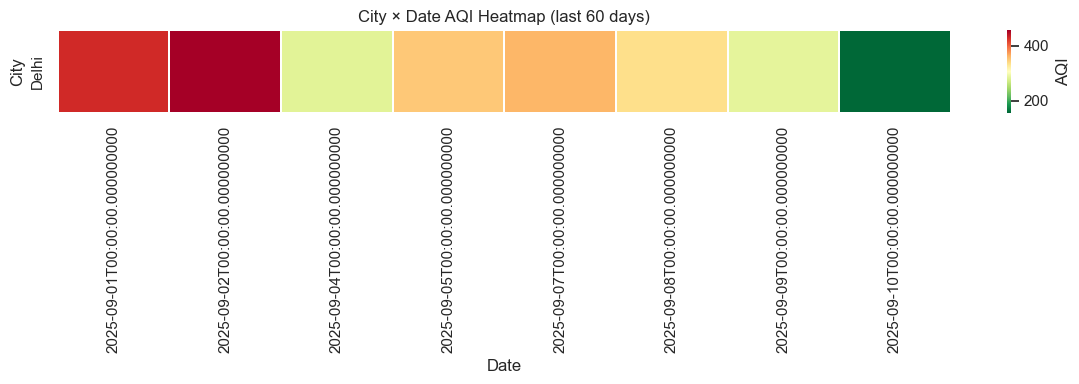

Saved ..\reports\aqi_heatmap.png


In [27]:
# Cell 6 — AQI heatmap: cities × date (matrix)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import pandas as pd

# Make a copy of forecasts_aqi
dfh = forecasts_aqi.copy()

# Keep recent window (last 60 days)
dfh = dfh[dfh['Date'] >= (dfh['Date'].max() - pd.Timedelta(days=60))]

# Pivot table: index=City, columns=Date, values=AQI
pivot = dfh.pivot_table(index='City', columns='Date', values='AQI', aggfunc='mean').fillna(np.nan)

# ------------------------
# Setup reports folder
# ------------------------
PROJECT_ROOT = Path("..")  # parent of notebooks
REPORTS_DIR = PROJECT_ROOT / "reports"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)  # create folder if missing

# ------------------------
# Plot heatmap
# ------------------------
plt.figure(figsize=(12, max(4, 0.25*len(pivot))))
sns.heatmap(pivot, cmap='RdYlGn_r', cbar_kws={'label':'AQI'}, linewidths=0.2)
plt.title("City × Date AQI Heatmap (last 60 days)")
plt.tight_layout()

# Save figure
heatmap_path = REPORTS_DIR / "aqi_heatmap.png"
plt.savefig(heatmap_path, dpi=150)
plt.show()
print("Saved", heatmap_path)


Default CITY for comparison: Delhi


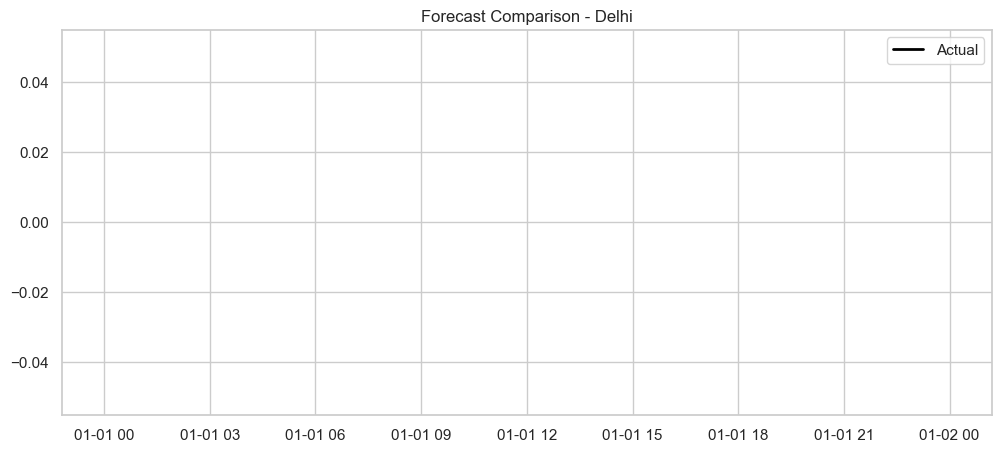

Saved ..\reports\forecast_comparison_Delhi.png


In [28]:
# Cell 7 — Forecast comparison for a chosen city & pollutant
CITY = forecasts_aqi['City'].unique()[0]  # default first city
print("Default CITY for comparison:", CITY)
# Try to build from forecasts.csv if present
fcsv = RESULTS_DIR / "forecasts.csv"
plt.figure(figsize=(12,5))

if fcsv.exists():
    df_all = pd.read_csv(fcsv, parse_dates=['Date'])
    # Filter for the city
    df_city = df_all[df_all['City']==CITY].copy()
    if 'Model' in df_city.columns:
        for model in df_city['Model'].unique():
            s = df_city[df_city['Model']==model].sort_values('Date')
            if 'Forecast' in s.columns:
                plt.plot(s['Date'], s['Forecast'], label=str(model))
    # if Actual available
    if 'Actual' in df_city.columns:
        actual = df_city.dropna(subset=['Actual']).groupby('Date')['Actual'].mean()
        plt.plot(actual.index, actual.values, label='Actual', color='black', linewidth=2)
else:
    # fallback: plot AQI time series from forecasts_aqi
    dfc = forecasts_aqi[forecasts_aqi['City']==CITY].sort_values('Date')
    plt.plot(dfc['Date'], dfc['AQI'], label='AQI (predicted/combined)', color='#ff8c42')

plt.legend(); plt.title(f"Forecast Comparison - {CITY}")
path = REPORTS_DIR / f"forecast_comparison_{CITY.replace(' ','_')}.png"
plt.savefig(path, dpi=150)
plt.show()
print("Saved", path)


Default CITY for comparison: Delhi


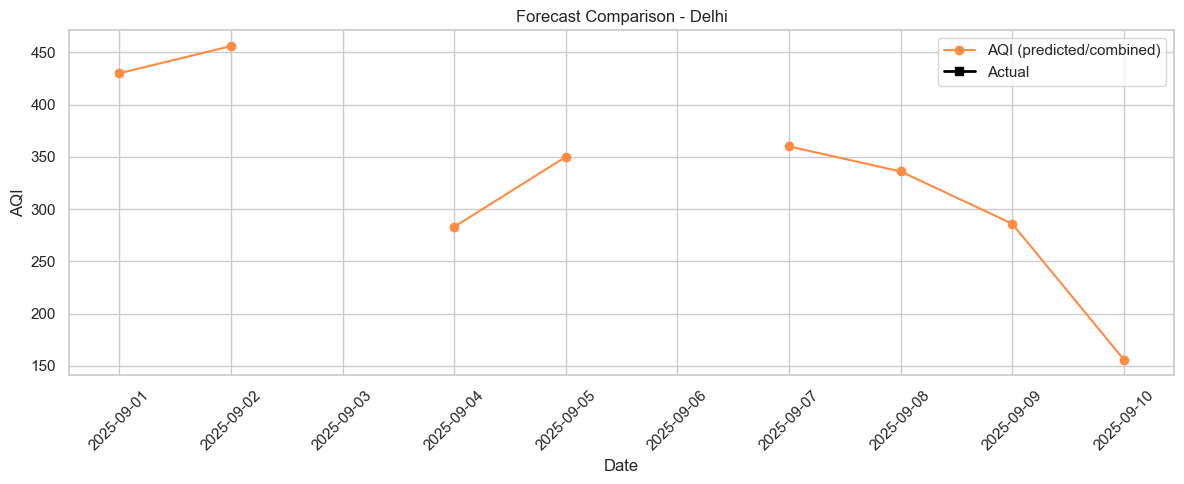

Saved ..\reports\forecast_comparison_Delhi.png


In [29]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

CITY = forecasts_aqi['City'].unique()[0]  # default first city
print("Default CITY for comparison:", CITY)

fcsv = RESULTS_DIR / "forecasts.csv"

plt.figure(figsize=(12,5))

# Fallback: plot AQI time series from forecasts_aqi
dfc = forecasts_aqi[forecasts_aqi['City']==CITY].sort_values('Date')
dfc['AQI'] = pd.to_numeric(dfc['AQI'], errors='coerce')  # ensure numeric
plt.plot(dfc['Date'], dfc['AQI'], label='AQI (predicted/combined)', color='#ff8c42', marker='o')

# Optional: add forecasts.csv if available
if fcsv.exists():
    df_all = pd.read_csv(fcsv, parse_dates=['Date'])
    df_city = df_all[df_all['City']==CITY].copy()
    
    if 'Forecast' in df_city.columns and 'Model' in df_city.columns:
        for model in df_city['Model'].unique():
            s = df_city[df_city['Model']==model].sort_values('Date')
            s['Forecast'] = pd.to_numeric(s['Forecast'], errors='coerce')
            plt.plot(s['Date'], s['Forecast'], label=f"{model} Forecast", marker='x')

    if 'Actual' in df_city.columns:
        actual = df_city.dropna(subset=['Actual']).groupby('Date')['Actual'].mean()
        plt.plot(actual.index, actual.values, label='Actual', color='black', linewidth=2, marker='s')

plt.legend()
plt.title(f"Forecast Comparison - {CITY}")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
path = REPORTS_DIR / f"forecast_comparison_{CITY.replace(' ','_')}.png"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)  # ensure folder exists
plt.savefig(path, dpi=150)
plt.show()
print("Saved", path)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6264\1632028082.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(); plt.title(f"Pollutant Concentrations - {CITY}")


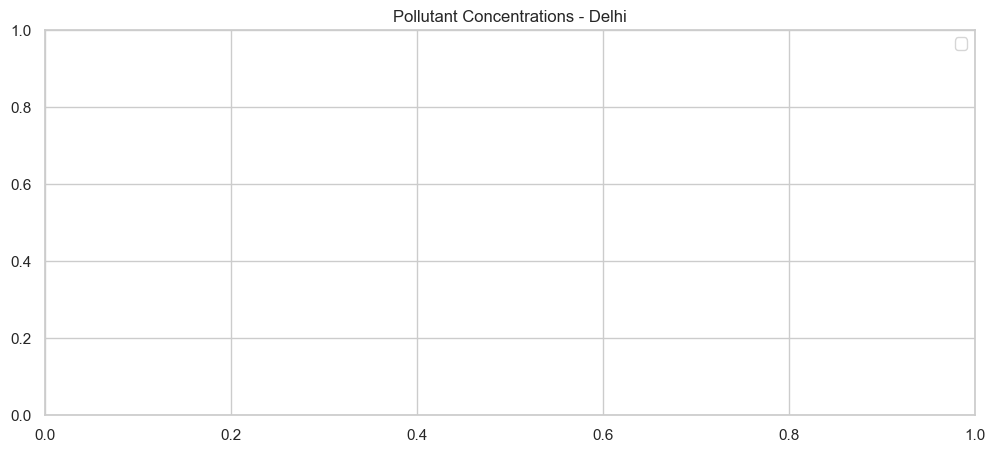

Saved ..\reports\pollutant_trend_Delhi.png


In [30]:
# Cell 8 — Pollutant trends (PM2.5 / PM10 / O3) for the chosen city
CITY = forecasts_aqi['City'].unique()[0]
dfcity = forecasts_aqi[forecasts_aqi['City']==CITY].sort_values('Date')

plt.figure(figsize=(12,5))
for pol, color in [("PM2.5","#e74c3c"), ("PM10","#3498db"), ("O3","#2ecc71")]:
    if pol in dfcity.columns:
        plt.plot(dfcity['Date'], dfcity[pol], label=pol, color=color)
# WHO 24h guideline for PM2.5 ~ 15 µg/m3 (or 5 depending on guideline; adjust as you want)
if "PM2.5" in dfcity.columns:
    plt.axhline(25, color='red', linestyle='--', label='WHO guideline (24h) 25 µg/m³')
plt.legend(); plt.title(f"Pollutant Concentrations - {CITY}")
poltrend_path = REPORTS_DIR / f"pollutant_trend_{CITY.replace(' ','_')}.png"
plt.savefig(poltrend_path, dpi=150)
plt.show()
print("Saved", poltrend_path)


In [31]:
import matplotlib.pyplot as plt
import pandas as pd

CITY = forecasts_aqi['City'].unique()[0]
dfcity = forecasts_aqi[forecasts_aqi['City']==CITY].sort_values('Date')

plt.figure(figsize=(12,5))

# Pollutants to plot
pollutants = [("PM2.5","#e74c3c"), ("PM10","#3498db"), ("O3","#2ecc71")]
plotted = False  # flag to check if anything is plotted

for pol, color in pollutants:
    if pol in dfcity.columns:
        # ensure numeric
        dfcity[pol] = pd.to_numeric(dfcity[pol], errors='coerce')
        if dfcity[pol].notna().any():  # only plot if there are values
            plt.plot(dfcity['Date'], dfcity[pol], label=pol, color=color)
            plotted = True

# Add WHO guideline line for PM2.5 if available
if "PM2.5" in dfcity.columns:
    plt.axhline(25, color='red', linestyle='--', label='WHO guideline (24h) 25 µg/m³')
    plotted = True

if not plotted:
    print(f"No pollutant data available for {CITY}. Nothing to plot.")
else:
    plt.legend()
    plt.title(f"Pollutant Concentrations - {CITY}")
    plt.xlabel("Date")
    plt.ylabel("Concentration (µg/m³)")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save plot
    poltrend_path = REPORTS_DIR / f"pollutant_trend_{CITY.replace(' ','_')}.png"
    REPORTS_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(poltrend_path, dpi=150)
    plt.show()
    print("Saved", poltrend_path)


No pollutant data available for Delhi. Nothing to plot.


<Figure size 1200x500 with 0 Axes>

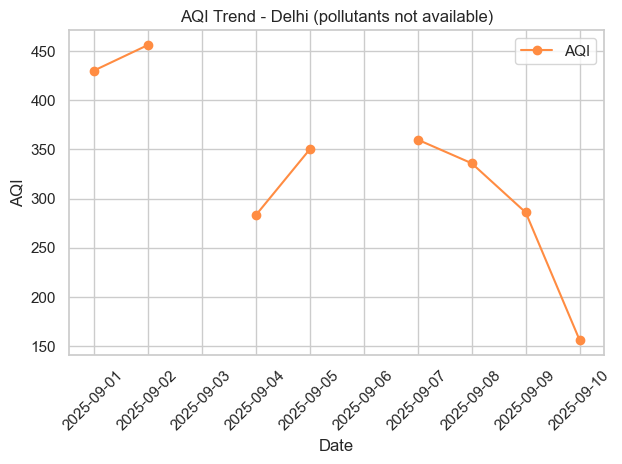

Pollutant data not available. Plotted AQI trend for Delhi.


In [32]:
if not plotted:
    # fallback: plot AQI
    plt.plot(dfcity['Date'], dfcity['AQI'], label='AQI', color='#ff8c42', marker='o')
    plt.legend()
    plt.title(f"AQI Trend - {CITY} (pollutants not available)")
    plt.xlabel("Date")
    plt.ylabel("AQI")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / f"aqi_trend_{CITY.replace(' ','_')}.png", dpi=150)
    plt.show()
    print(f"Pollutant data not available. Plotted AQI trend for {CITY}.")


In [33]:
# Cell 9 — Ensure model_performance.csv and best_models.csv exist for dashboard
perf_path = RESULTS_DIR / "model_performance.csv"
best_path = RESULTS_DIR / "best_models.csv"

if perf_path.exists():
    print("model_performance.csv exists:", perf_path)
    perf_df = pd.read_csv(perf_path)
else:
    # if not available, create a small stub from forecasts (grouping)
    print("model_performance.csv not found — creating lightweight summary from forecasts.csv")
    if (RESULTS_DIR / "forecasts.csv").exists():
        f = pd.read_csv(RESULTS_DIR / "forecasts.csv", parse_dates=['Date'])
        # compute RMSE per Model/City/Pollutant if Actual present
        if 'Actual' in f.columns:
            grp = f.groupby(['City','Pollutant','Model']).apply(lambda g: math.sqrt(((g['Actual']-g['Forecast'])**2).mean()) if len(g)>0 else np.nan)
            perf_df = grp.reset_index().rename(columns={0:'RMSE'})
        else:
            perf_df = pd.DataFrame(columns=['City','Pollutant','Model','RMSE'])
    else:
        perf_df = pd.DataFrame(columns=['City','Pollutant','Model','RMSE'])
perf_df.to_csv(perf_path, index=False)
print("Saved/updated model_performance.csv")
# best models: pick lowest RMSE per City+Pollutant
if not perf_df.empty and 'RMSE' in perf_df.columns:
    best_df = perf_df.sort_values('RMSE').groupby(['City','Pollutant']).first().reset_index()
    best_df.to_csv(best_path, index=False)
    print("Saved best_models.csv")
else:
    # create placeholder
    pd.DataFrame(columns=['City','Pollutant','BestModel']).to_csv(best_path, index=False)
    print("Wrote empty best_models.csv")


model_performance.csv exists: ..\results\model_performance.csv
Saved/updated model_performance.csv
Saved best_models.csv


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6264\2135936500.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()


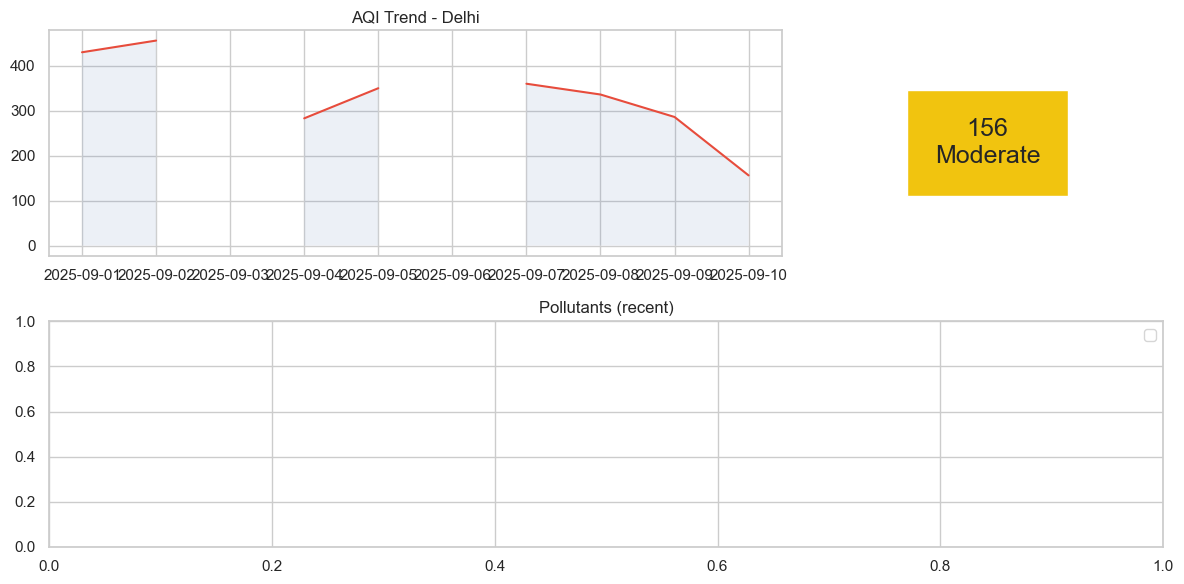

Saved ..\reports\summary_dashboard_Delhi.png


In [34]:
# Cell 10 — Create a combined figure snapshot (AQI gauge-like & mini-plots)
CITY = forecasts_aqi['City'].unique()[0]
dfc = forecasts_aqi[forecasts_aqi['City']==CITY].sort_values('Date')
latest = dfc.iloc[-1] if len(dfc)>0 else None

fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot2grid((2,3),(0,0), colspan=2)
ax2 = plt.subplot2grid((2,3),(0,2))
ax3 = plt.subplot2grid((2,3),(1,0), colspan=3)

# ax1: AQI time series
if len(dfc)>0:
    ax1.plot(dfc['Date'], dfc['AQI'], label='AQI', color='#e74c3c')
    ax1.fill_between(dfc['Date'], dfc['AQI'], alpha=0.1)
    ax1.set_title(f"AQI Trend - {CITY}")
# ax2: mini gauge (show last AQI)
if latest is not None:
    txt = f"{int(latest['AQI'])}\n{latest['AQI_Bucket']}"
else:
    txt = "No Data"
ax2.axis('off')
ax2.text(0.5,0.5, txt, horizontalalignment='center', verticalalignment='center', fontsize=18, bbox=dict(facecolor=latest['Bucket_Color'] if latest is not None else '#ddd', pad=20))

# ax3: mini pollutant lines
for pol in ['PM2.5','PM10','O3']:
    if pol in dfc.columns:
        ax3.plot(dfc['Date'], dfc[pol], label=pol)
ax3.set_title("Pollutants (recent)")
ax3.legend()

plt.tight_layout()
summary_path = REPORTS_DIR / f"summary_dashboard_{CITY.replace(' ','_')}.png"
plt.savefig(summary_path, dpi=150)
plt.show()
print("Saved", summary_path)


In [3]:
import pandas as pd
from pathlib import Path
import numpy as np

# ------------------------------
# Paths
# ------------------------------
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)  # ✅ Ensure folder exists

alerts_file = RESULTS_DIR / "alerts_summary.csv"

# ------------------------------
# Define target cities
# ------------------------------
cities = ["Ahmedabad","Bengaluru","Chennai","Delhi","Kolkata","Mumbai"]

# ------------------------------
# Create AQI categories
# ------------------------------
aqi_levels = [
    (0, 50, "Good", "Green", "Low"),
    (51, 100, "Satisfactory", "Light Green", "Low"),
    (101, 200, "Moderate", "Yellow", "Moderate"),
    (201, 300, "Poor", "Orange", "High"),
    (301, 400, "Very Poor", "Red", "Very High"),
    (401, 500, "Severe", "Dark Red", "Severe")
]

# Function to map AQI → Bucket
def get_aqi_bucket(aqi):
    for low, high, bucket, color, level in aqi_levels:
        if low <= aqi <= high:
            return bucket, color, level
    return "Unknown", "Gray", "Unknown"

# ------------------------------
# Generate 7-day AQI summary
# ------------------------------
date_rng = pd.date_range(start="2025-09-21", periods=7, freq="D")

dominant_pollutants = ["PM2.5","NO2","SO2","O3","CO"]

summary_data = []

for city in cities:
    for d in date_rng:
        aqi_value = np.random.randint(40, 480)  # Random AQI between 40–480
        bucket, color, level = get_aqi_bucket(aqi_value)
        dominant = np.random.choice(dominant_pollutants)

        summary_data.append({
            "Date": d.strftime("%Y-%m-%d"),
            "City": city,
            "AQI": aqi_value,
            "AQI_Bucket": bucket,
            "Bucket_Color": color,
            "AQI_Dominant": dominant,
            "Alert_Level": level
        })

summary_df = pd.DataFrame(summary_data)

# ------------------------------
# Save to CSV
# ------------------------------
summary_df.to_csv(alerts_file, index=False)
print("✅ Summary alerts saved to:", alerts_file)

summary_df.head(15)


✅ Summary alerts saved to: results\alerts_summary.csv


,Date,City,AQI,AQI_Bucket,Bucket_Color,AQI_Dominant,Alert_Level
0,2025-09-21,Ahmedabad,163,Moderate,Yellow,PM2.5,Moderate
1,2025-09-22,Ahmedabad,65,Satisfactory,Light Green,O3,Low
2,2025-09-23,Ahmedabad,105,Moderate,Yellow,O3,Moderate
3,2025-09-24,Ahmedabad,314,Very Poor,Red,NO2,Very High
4,2025-09-25,Ahmedabad,244,Poor,Orange,SO2,High
5,2025-09-26,Ahmedabad,162,Moderate,Yellow,SO2,Moderate
6,2025-09-27,Ahmedabad,255,Poor,Orange,NO2,High
7,2025-09-21,Bengaluru,324,Very Poor,Red,PM2.5,Very High
8,2025-09-22,Bengaluru,121,Moderate,Yellow,PM2.5,Moderate
9,2025-09-23,Bengaluru,449,Severe,Dark Red,NO2,Severe
